### Carregando as bibliotecas

Para a plataforma Windows, utilize a versão 4.0.0 do Pillow, utilizando o seguinte comando para instalar ```conda install -c anaconda pillow ```.

A instalação do Keras é pelo comando ```conda install -c anaconda keras```. Automaticamente será instalado as dependâncias como  _TensorFlow_.

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [6]:
keras.__version__

'2.2.2'

### Criando os geradores

Foram utilizadas imagens com tamanho 250 x 250 pixels, 347 imagens por classe para o treinamento e 100 imagens por classe para validação.

Os geradores utilizados foram aplicados para converter o tamnaho adequado do modelo utilizado (224 x 224 pixels) como também para criar novos exemplos a partir das imagens no que chamamos de _data augmentation_, por meio de perturbações da imagem baseado em recorte (```shear```), zoom e orientação horizontal (```horizontal_flip```).

Com a técnica de _data augmentation_ foram geradas 1212 imagens por classe. Ao todo, o número de imagens subiu de 794 para 2424.

In [53]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "data/train", save_to_dir="data/gen",
    batch_size=32,
    class_mode="binary",
    target_size=(224,224))

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    "data/validation",
    shuffle=False,
    class_mode="binary",
    target_size=(224,224))

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### Construindo a rede neural baseado em modelo pré-treinado

O Keras já possui classes especializadas para os seguintes modelos de deep-learning treinados com o conjunto de dados [ImageNet](http://www.image-net.org/):
  
* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet
* MobileNetV2

Mais detalhes, veja na [documentação do Keras](https://keras.io/applications/).

_O Keras se encarrega de baixar o modelo automaticamente, não é preciso baixar separadamente._

Note que o parâmetro ```include_top=False``` configura o modelo para não utilizar a camada densa original, pois será substituída pelas novas classes.

In [55]:
conv_base = ResNet50(include_top=False, weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

C:\Users\Michel.Fernandes\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Removendo a camada densa para que seja adaptada para lidar com apenas 2 classes.

In [56]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [57]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Treinamento do modelo

In [58]:
history = model.fit_generator(generator=train_generator, epochs=3, validation_data=validation_generator)

Epoch 1/3
22/22 [==============================] - 1055s 48s/step - loss: 0.6497 - acc: 0.6962 - val_loss: 0.2581 - val_acc: 0.9100
Epoch 2/3
22/22 [==============================] - 906s 41s/step - loss: 0.1874 - acc: 0.9176 - val_loss: 0.5408 - val_acc: 0.7900
Epoch 3/3
22/22 [==============================] - 858s 39s/step - loss: 0.1801 - acc: 0.9198 - val_loss: 0.1856 - val_acc: 0.9200


### Armazenamento e carregamento do modelo

In [13]:
# salvando o modelo no formato HDf5
model.save('models/keras/model.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
    f.write(model.to_json())

In [21]:
# carregando o modelo no formato HDf5
model = load_model('models/keras/model.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')

### Predição nas imagens de teste

In [22]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

Normalizando as imagens de teste, como neste caso não usamos o gerador do Keras, precisamos ajustar manualmente.

In [23]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224)))) for img in img_list])

In [24]:
pred_probs = model.predict(validation_batch)

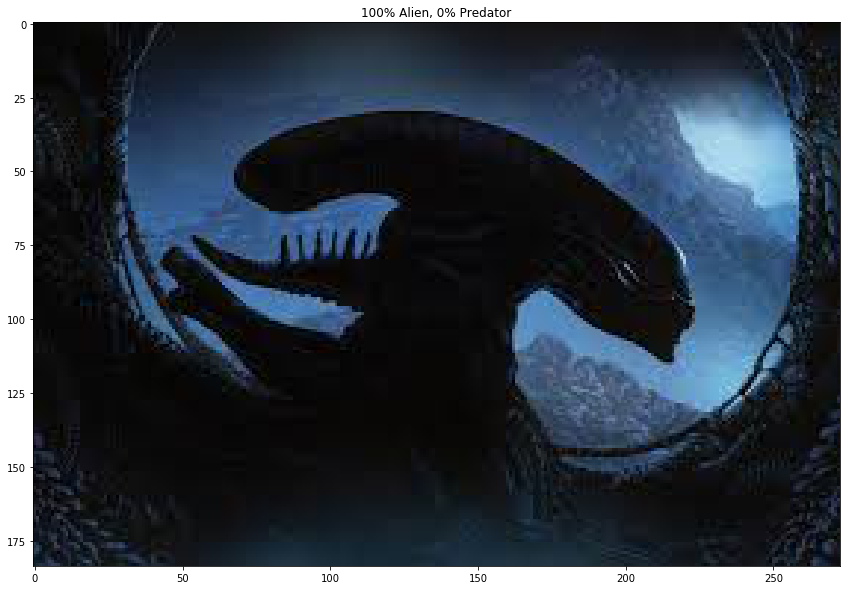

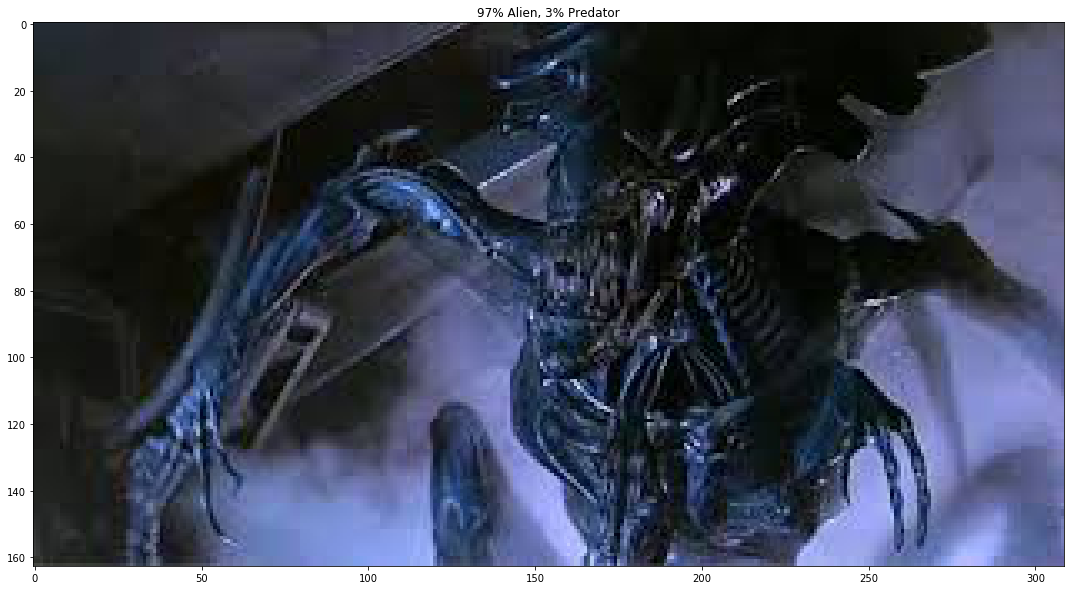

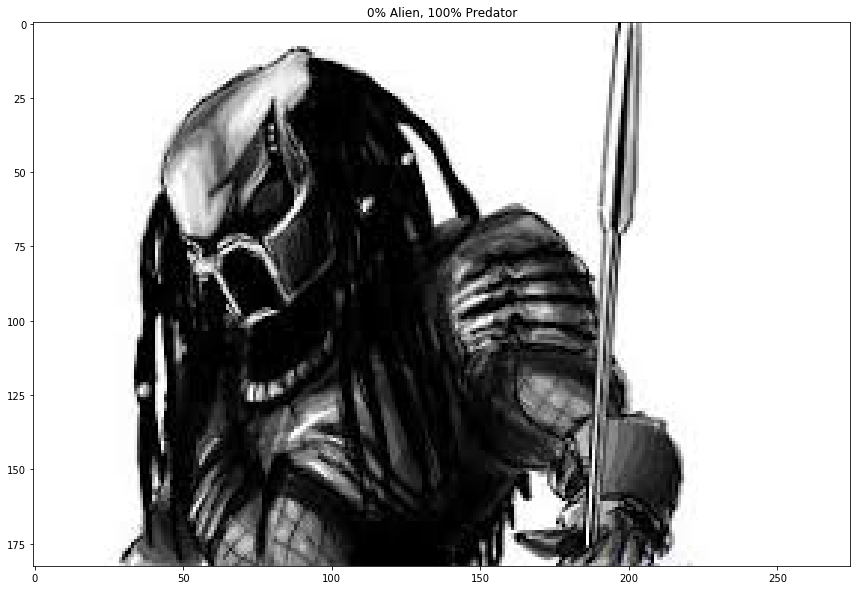

In [69]:
for i, img in enumerate(img_list):
    fig, axs = plt.subplots(1, 1, figsize=(25, 10))
    axs.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0], 100*pred_probs[i,1]))
    axs.imshow(img)